In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_dataset
import torch

In [7]:
df = load_dataset("knkarthick/samsum")

In [8]:
df_train = df['train']
df_validate = df['validation']
df_test = df['test']

In [54]:
df_train['dialogue']

["Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'Olivia: Who are you voting for in this election? \nOliver: Liberals as always.\nOlivia: Me too!!\nOliver: Great',
 "Tim: Hi, what's up?\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\nTim: What did you plan on doing?\nKim: Oh you know, uni stuff and unfucking my room\nKim: Maybe tomorrow I'll move my ass and do everything\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\nTim: It really helps\nKim: thanks, maybe I'll do that\nTim: I also like using post-its in kaban style",
 "Edward: Rachel, I think I'm in ove with Bella..\nrachel: Dont say anything else..\nEdward: What do you mean??\nrachel: Open your fu**ing door.. I'm outside",
 "Sam: hey  overheard rick say something\nSam: i don't know what to do :-/\nNaomi: what did 

In [55]:
conversations = pd.DataFrame(columns=['Original','Utterances'])

In [133]:
def split_utterances(convo_string):
    #patt = re.compile(r'([A-Za-z]+): (.{0,})$')
    errs = {}
    patt = re.compile(r'^(.{1,}): (.{0,})$')
    dialogue = convo_string.split('\n')
    utterances = {}
    i = 0
    for d in dialogue:
        try:
            grps = patt.match(d).groups()
            speaker = grps[0]
            utterance = grps[1]
            utterances[i] = (speaker,utterance)
            i+=1
        except:
            errs[i] = d
            i+=1
    return utterances,errs
    

    

In [134]:
def analyze_conversation(utterances):
    metrics = {}
    metrics['utterances'] = len(utterances)
    utterers = set(utterance[0] for utterance in utterances.values())
    chars = sum(len(utterance[1]) for utterance in utterances.values())
    metrics['utterers'] = len(utterers)
    share_u = dict.fromkeys(utterers,0)
    share_w = dict.fromkeys(utterers,0)
    for utter in utterances.values():
        share_u[utter[0]]+=1
        share_w[utter[0]]+=len(utter[1])
    
    metrics['share_by_utterance'] = sum((val/metrics['utterances'])**2 for _,val in share_u.items())
    metrics['share_by_length'] = sum((val/chars)**2 for _,val in share_w.items())

    return metrics

In [58]:
conversations['Original'] = df_train['dialogue']

In [152]:
samples = {}
errs = {}
count = 0
for d in df_train['dialogue']:
    if d is not None:
        results = split_utterances(d)
        samples[count] = results[0]
        if(len(results[1])>0): 
           errs[count] = results[1]
        count+=1


In [161]:
results = {}
errs_2 = {}

for count,sample in samples.items():
    results[count] = analyze_conversation(sample)


In [166]:
stats = pd.DataFrame(results).T
stats

,utterances,utterers,share_by_utterance,share_by_length
0,3.0,2.0,0.555556,0.861885
1,4.0,2.0,0.500000,0.558641
2,10.0,2.0,0.500000,0.524584
3,4.0,2.0,0.500000,0.500329
4,22.0,2.0,0.504132,0.505745
...,...,...,...,...
14726,7.0,2.0,0.510204,0.557407
14727,19.0,2.0,0.512465,0.508413
14728,14.0,3.0,0.357143,0.351512
14729,21.0,2.0,0.501134,0.507405


In [167]:
stats.describe()

,utterances,utterers,share_by_utterance,share_by_length
count,14731.000000,14731.000000,14731.000000,14731.000000
mean,11.160749,2.423732,0.467379,0.501069
std,6.450276,0.855280,0.084949,0.101846
min,2.000000,2.000000,0.081633,0.092088
25%,6.000000,2.000000,0.420000,0.485168
50%,10.000000,2.000000,0.500000,0.507664
75%,15.000000,3.000000,0.510204,0.541015
max,46.000000,14.000000,0.755102,0.984253


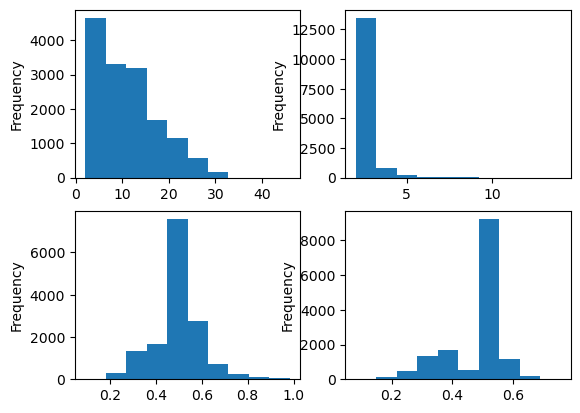

In [179]:
fig,axs = plt.subplots(nrows=2,ncols=2)
stats.utterances.plot.hist(ax=axs[0][0]);
stats.utterers.plot.hist(ax=axs[0][1]);
stats.share_by_utterance.plot.hist(ax=axs[1][1]);
stats.share_by_length.plot.hist(ax=axs[1][0]);


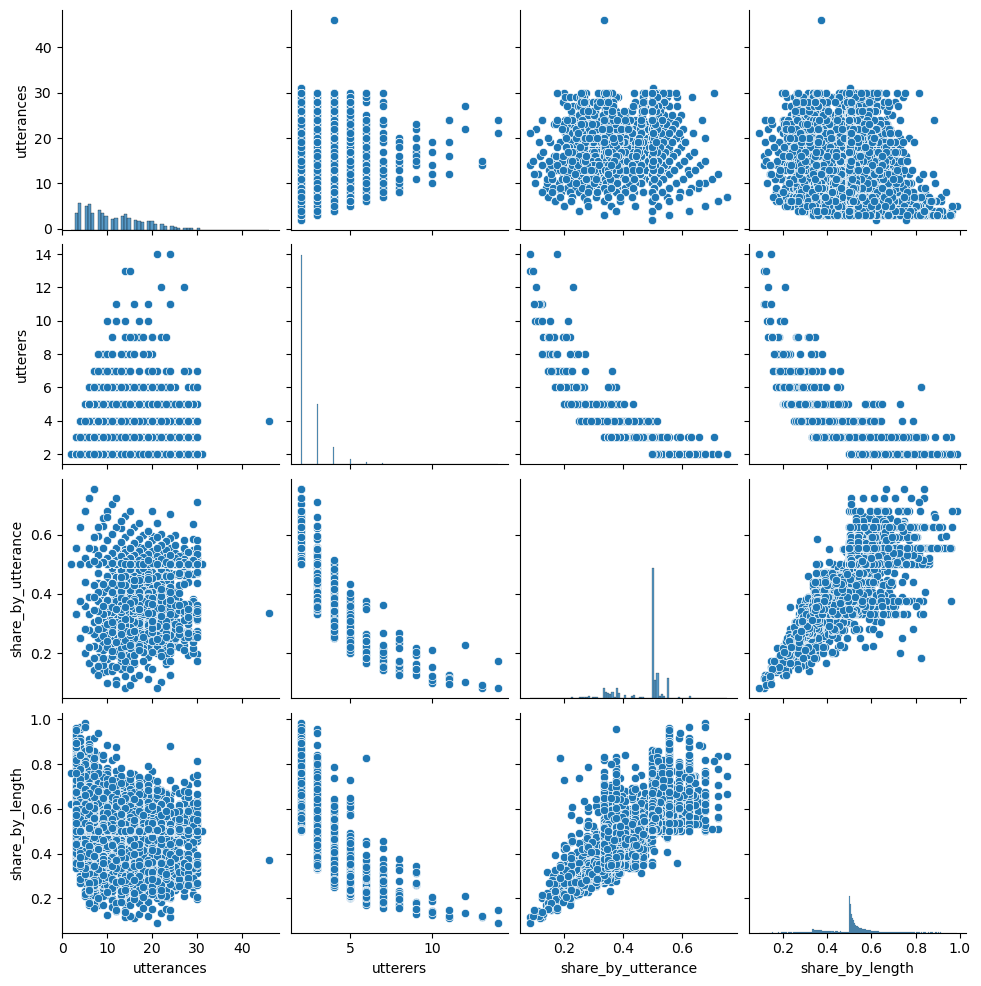

In [ ]:
sns.pairplot(data=stats);